# Data analysis - `keras`

In [ ]:
import os
import numpy as np
import pickle
import nibabel as nb
import pandas as pd
from scipy.stats import zscore
from keras import layers, models, optimizers, regularizers
from random import shuffle
from sklearn import decomposition

# Create dataset

In [ ]:
def read_dataset(filename, n_components=100):

    # Read csv file
    df = pd.read_csv(filename)

    # extract relevant variables
    sub_id = np.array(df['PAC_ID'])
    label = np.array(df['Label'] - 1)
    scanner = np.array(df['Scanner'])
    
    # split into input (X) and output (Y) variables
    df = df.drop(['Scanner','Label', 'PAC_ID'], 1)
    ica = decomposition.FastICA(n_components=n_components)
    data = np.array(df)
    ica.fit(data)
    data = ica.transform(data)

    return data, sub_id, label, scanner

In [ ]:
n_components = 100
data, sub_id, label, scanner = read_dataset('data/PAC2018_Covariates_pooling_red10_max.csv', n_components)

# Create dataset (select dataset, balance it and divide train and validation)

In [ ]:
def balance_dataset(sub_id, labels, data):
    max_label_size = np.min([np.sum(lab == labels) 
                             for lab in np.unique(labels)])

    labels_1 = np.where(labels == 0)[0]
    np.random.shuffle(labels_1)
    labels_1 = labels_1[:max_label_size]

    labels_2 = np.where(labels == 1)[0]
    np.random.shuffle(labels_2)
    labels_2 = labels_2[:max_label_size]

    new_data_id = np.hstack((labels_1, labels_2))
    np.random.shuffle(new_data_id)
    labels = labels[new_data_id]
    sub_id = sub_id[new_data_id]
    data = data[new_data_id]

    return (sub_id, labels, data)

In [ ]:
def get_train_valid_set(sub_id, label, data, scanner, group='123', train_ratio=0.8):
    
    selecter = [str(int(d)) in group for d in scanner]

    group_sub, group_label, group_data = balance_dataset(
        sub_id[selecter], label[selecter], np.array(data[selecter]))
    
    
    train_size = int(len(group_sub) * train_ratio)
    valid_size = len(group_sub) - train_size

    counter1 = 0
    counter2 = 0
    train_list = []

    for i, s in enumerate(group_sub):
        if counter1 < (train_size / 2) and group_label[i] == 0:
            train_list.append(s)
            counter1 += 1
        elif counter2 < (train_size / 2) and group_label[i] == 1:
            train_list.append(s)
            counter2 += 1

    selecter = np.array([True if e in train_list else False for i, e in enumerate(group_sub)])

    train_list = group_sub[selecter]
    valid_list = group_sub[np.invert(selecter)]
    
    return train_list, valid_list, group_sub, group_label, group_data

# `Keras` model

In [ ]:
def data_gen(fileList, batch):

    while True:
        for r in range(0, len(fileList), batch):

            batch_data = []
            batch_label = []

            for i in range(batch):
                if r + i >= len(fileList):
                    break
                else:

                    patientID = fileList[r]

                    # Get data for each subject
                    batch_data.append(group_data[group_sub == patientID][0])

                    # Get data for each label
                    labelID = group_label[group_sub == patientID]
                    batch_label.append(labelID)

            yield (np.array(batch_data), np.array(batch_label))

In [ ]:
# Neural network definition
model = models.Sequential()

model.add(layers.Dense(64, activation='relu', name='input',
                       input_shape=(n_components,), batch_size=None))
model.add(layers.Dense(1, activation='sigmoid', name='output'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Batch size
batch_size = 25

# Training to Validation set ratio
train_ratio=0.8

In [ ]:
# Create Groups
group_id = '123'
train_list, valid_list, group_sub, group_label, group_data = get_train_valid_set(
    sub_id, label, data, scanner, group=group_id, train_ratio=0.8)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
history = model.fit_generator(
    data_gen(train_list, batch_size),
    steps_per_epoch=int(np.ceil(len(train_list) / batch_size)),
    validation_data=data_gen(valid_list, batch_size),
    validation_steps=int(np.ceil(len(valid_list) / batch_size)),
    epochs=200, shuffle=True)

Epoch 1/200
49/49 [==============================] - 1s 12ms/step - loss: 0.6930 - binary_accuracy: 0.4491 - val_loss: 0.6896 - val_binary_accuracy: 0.5757
Epoch 2/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6929 - binary_accuracy: 0.4491 - val_loss: 0.6895 - val_binary_accuracy: 0.5757
Epoch 3/200
49/49 [==============================] - 0s 5ms/step - loss: 0.6928 - binary_accuracy: 0.4491 - val_loss: 0.6895 - val_binary_accuracy: 0.5757
Epoch 4/200
49/49 [==============================] - 0s 5ms/step - loss: 0.6927 - binary_accuracy: 0.4491 - val_loss: 0.6894 - val_binary_accuracy: 0.5757
Epoch 5/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6925 - binary_accuracy: 0.4695 - val_loss: 0.6894 - val_binary_accuracy: 0.5757
Epoch 6/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6924 - binary_accuracy: 0.4899 - val_loss: 0.6893 - val_binary_accuracy: 0.5757
Epoch 7/200
49/49 [==============================] - 0s 6ms/step - lo

49/49 [==============================] - 0s 7ms/step - loss: 0.6820 - binary_accuracy: 0.8979 - val_loss: 0.6852 - val_binary_accuracy: 0.6711
Epoch 106/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6819 - binary_accuracy: 0.8979 - val_loss: 0.6852 - val_binary_accuracy: 0.6711
Epoch 107/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6818 - binary_accuracy: 0.8979 - val_loss: 0.6852 - val_binary_accuracy: 0.6711
Epoch 108/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6817 - binary_accuracy: 0.8979 - val_loss: 0.6851 - val_binary_accuracy: 0.6711
Epoch 109/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6816 - binary_accuracy: 0.8979 - val_loss: 0.6851 - val_binary_accuracy: 0.6711
Epoch 110/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6815 - binary_accuracy: 0.8979 - val_loss: 0.6851 - val_binary_accuracy: 0.6711
Epoch 111/200
49/49 [==============================] - 0s 6ms/step - los

In [ ]:
print('Group: %s\tTotal: %s' % (round(model.evaluate(group_data, group_label, batch_size=batch_size)[1] * 100, 2),
                                round(model.evaluate(data, label, batch_size=batch_size)[1] * 100, 2)))

1792/1792 [==============================] - 0s 39us/step
Group: 52.5	Total: 56.08


In [ ]:
train_id = [s in train_list for s in group_sub]
valid_id = [s in valid_list for s in group_sub]

In [ ]:
print('Train: %s\tValid: %s' % (round(model.evaluate(group_data[train_id], group_label[train_id], batch_size=batch_size)[1] * 100, 2),
                                round(model.evaluate(group_data[valid_id], group_label[valid_id], batch_size=batch_size)[1] * 100, 2)))

304/304 [==============================] - 0s 49us/step
Train: 53.05	Valid: 50.33


# Visualize results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

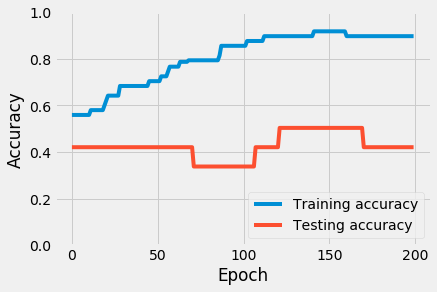

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=4)

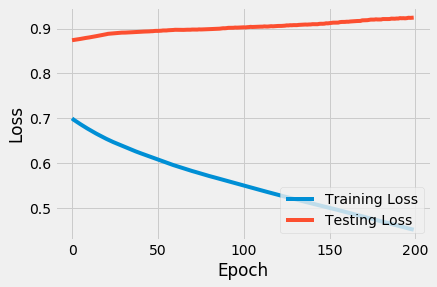

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=4)

# Save really good models

In [ ]:
version = 98
model.save('model_1D_g%s_v%03d.h5' % (group_id, version))
with open('./trainHistory_1D_g%s_v%03d' % (group_id, version), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Load a model and validate it against the whole dataset

In [ ]:
model = models.load_model('model_1D_g23_v006.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 64)                8128      
_________________________________________________________________
hidden-4 (Dense)             (None, 64)                4160      
_________________________________________________________________
hidden-3 (Dense)             (None, 64)                4160      
_________________________________________________________________
drop-2 (Dropout)             (None, 64)                0         
_________________________________________________________________
hidden-2 (Dense)             (None, 32)                2080      
_________________________________________________________________
drop-1 (Dropout)             (None, 32)                0         
_________________________________________________________________
hidden-1 (Dense)             (None, 32)                1056      
__________

In [ ]:
print('Group: %s\tTotal: %s' % (round(model.evaluate(group_data, group_label, batch_size=batch_size)[1] * 100, 2),
                                round(model.evaluate(data, label, batch_size=batch_size)[1] * 100, 2)))

1784/1784 [==============================] - 0s 12us/step
Group: 50.0	Total: 57.68


In [ ]:
train_id = [s in train_list for s in group_sub]
valid_id = [s in valid_list for s in group_sub]
print('Train: %s\tValid: %s' % (round(model.evaluate(group_data[train_id], group_label[train_id], batch_size=batch_size)[1] * 100, 2),
                                round(model.evaluate(group_data[valid_id], group_label[valid_id], batch_size=batch_size)[1] * 100, 2)))

302/302 [==============================] - 0s 21us/step
Train: 50.0	Valid: 50.0
